In [43]:
import subprocess
import json
import matplotlib.pyplot as plt
import numpy as np

In [16]:
result = subprocess.run([
    './src/bunker-net-sim', 
    '-r', 
    '0', 
    '-m', 
    '-u', 
    'Cmdenv', 
    '-n', 
    './simulations:./src:../../omnetpp-6.0.1/samples/inet4.4/src', 
    '--image-path=../../omnetpp-6.0.1/samples/inet4.4/images', 
    '-l', 
    '../../omnetpp-6.0.1/samples/inet4.4/src/INET', 
    './simulations/omnetpp.ini'], 
    stdout = subprocess.PIPE)

runLog = result.stdout.decode('utf-8').splitlines()
print(*runLog, sep='\n')

OMNeT++ Discrete Event Simulation  (C) 1992-2022 Andras Varga, OpenSim Ltd.
Version: 6.0.1, build: 220831-e4f07d04b8, edition: Academic Public License -- NOT FOR COMMERCIAL USE
See the license for distribution terms and warranty disclaimer

Setting up Cmdenv...

Loading NED files from ./simulations:  1
Loading NED files from ./src:  4
Loading NED files from ../../omnetpp-6.0.1/samples/inet4.4/src:  1166

Preparing for running configuration General, run #0...
Scenario: $bnum=int(uniform(2, 5)), $hnum=int(uniform(2, 5)), $xnum=int(uniform(1, 2)), $repetition=0
Assigned runID=General-0-20221214-02:32:22-46530
Setting up network "Network"...
Initializing...

Running simulation...
** Event #0   t=0   Elapsed: 1.5e-05s (0m 00s)  0% completed  (0% total)
     Speed:     ev/sec=0   simsec/sec=0   ev/simsec=0
     Messages:  created: 457   present: 457   in FES: 26
** Event #18577   t=300   Elapsed: 0.073558s (0m 00s)  100% completed  (100% total)
     Speed:     ev/sec=252621   simsec/sec=4079

In [22]:
res = subprocess.run(['../../omnetpp-6.0.1/bin/opp_scavetool', 'x', './simulations/results/vectors.vec', '-F', 'JSON', '-o', 'vectors.json'], 
    stdout = subprocess.PIPE)

runLog = res.stdout.decode('utf-8').splitlines()
print(*runLog, sep='\n')

Exported 554 vectors


In [23]:
res = subprocess.run(['../../omnetpp-6.0.1/bin/opp_scavetool', 'x', './simulations/results/scalars.sca', '-F', 'JSON', '-o', 'scalars.json'], 
    stdout = subprocess.PIPE)

runLog = res.stdout.decode('utf-8').splitlines()
print(*runLog, sep='\n')

Exported 2045 scalars, 4911 parameters, 25 statistics, 128 histograms


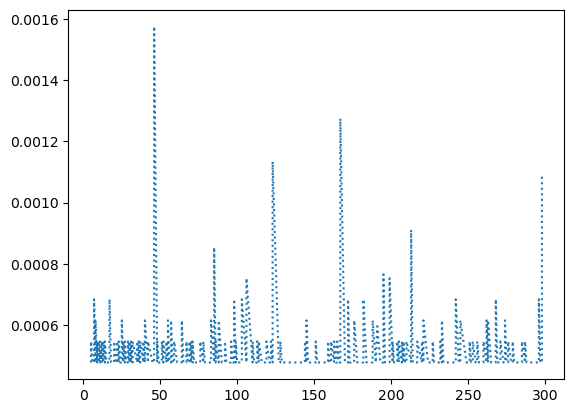

In [46]:
with open('vectors.json') as f:
    vectors = json.loads(f.read())

for key in vectors.keys():
    data = vectors[key]['vectors']
    
    for d in data:
        if d['module'] == "Network.server.app[0]" and d['name'] == 'endtoenddelay:vector':
            time = d['time']
            value = d['value']
            xpoints = np.array(time)
            ypoints = np.array(value)
            plt.plot(xpoints, ypoints, linestyle = 'dotted')
            plt.savefig('server-rtt.png', bbox_inches='tight')